# **ANEXOS**

En este primer ANEXO se incluye los modelos MARS y SSA

# Librerias

In [1]:
# Manipulación y análisis de datos
library(tidyverse)  # Incluye dplyr, ggplot2, readr, etc.
library(dplyr)      # Incluido en tidyverse, pero lo puedes dejar explícito si quieres
library(fields)      # Manipulación de datos espaciales

# Modelado
library(earth)       # Modelos MARS
library(mgcv)        # Modelos GAM
library(caret)       # Machine learning

# Series de tiempo
library(tseries)     # Análisis de series de tiempo
library(tsfeatures)  # Extracción de features de series de tiempo
library(forecast)    # Modelado y pronóstico de series de tiempo
library(quantmod)    # Datos financieros
library(xts)         # Objetos de series de tiempo extensibles
library(Rssa)        # Singular Spectrum Analysis
library(TTR)         # Technical Trading Rules
# library(TSA)       # Si necesitas TSA, descomenta

# Visualización
library(ggplot2)     # Gráficos (ya incluido en tidyverse)
library(dygraphs)    # Visualización interactiva de series de tiempo

# Métricas y rendimiento
library(Metrics)               # Métricas de error
library(yardstick)

# Configuración global
theme_set(theme_bw())
options(warn = -1)

# Exploración inicial
list.files(path = "../input")


Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘tidyr’ was built under R version 4.2.3”
Warning message:
“package ‘readr’ was built under R version 4.2.3”
Warning message:
“package ‘dplyr’ was built under R version 4.2.3”
Warning message:
“package ‘stringr’ was built under R version 4.2.3”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: spam

Spam version 2.10-0 (2023-10-23) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 

character(0)

# **PASO 1:Aplicación de los modelos**

### **1. Descarga de Yahoo Finance la serie de precios de cierre del activo META en las fechas: 01-05-2016 al 28-01-2018.**

In [2]:
###Función para obtener datos:
start<-format(as.Date("2016-05-01"),"%Y-%m-%d")
end<-format(as.Date("2018-01-28"),"%Y-%m-%d")

precios <-function(simbolo)
{
  ##Obtener precios stocks de Yahoo FInance
  datos <- getSymbols(simbolo, auto.assign = FALSE, from=start, to=end)
  ## Elimar faltantes:
  datos<-na.omit(datos)
  ##mantener columnas con precios cierre 4:
  datos <- datos[,4]
  ##Para hacerlo datos accesibles en el global environment:
  assign(simbolo, datos, envir = .GlobalEnv)
}
##Llamar el activo de interés, pueden ser varios:
precios("META")


### **2. Grafica la serie**

In [3]:
##Juntar los datos y renombrarlos:
Pr<-merge.xts(META) %>% na.omit()
colnames(Pr) <- c("META")
##Serie tiempo, grafica interactiva
Precios<- dygraph(Pr[,c(1)], main="Precios ") %>%
  dyAxis("y", label = "Precios") %>%
  dyRangeSelector(dateWindow = c("2016-05-01", "2018-01-28"))%>%
  dyOptions(colors = RColorBrewer::brewer.pal(4,"Set1"))
Precios

HTML widgets cannot be represented in plain text (need html)

### **3. Prepara los datos a manera que cuentes con un formato adecuado para la fecha.**

In [4]:
##Index format.
xpr <- as.xts(Pr, dateFormat = "Date")
Pr_index <- fortify.zoo(xpr)
nrow(Pr)

[1] 439

### **4. Parte la serie a un 5% de prueba y el restante para el entrenamiento.**

In [5]:
#Partimos serie para train & test
h <- round(length(Pr)*0.05, digits = 0 )
Pr_tra <- Pr[1:(nrow(Pr) - h), ]
Pr_tes<- Pr[(nrow(Pr) - h + 1):nrow(Pr), ]

#Pasamos a formato data frame para poder generar los retrasos
Pr_df_tra<-as.data.frame(Pr_tra)

### **5. Realiza el preprocesamiento necesario para aplicar cada uno de los modelos**

**5.1 Preprocesamiento MARS**

frequency,nperiods,seasonal_period,trend,spike,linearity,curvature,e_acf1,e_acf10,entropy,x_acf1,x_acf10,diff1_acf1,diff1_acf10,diff2_acf1,diff2_acf10
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,1,0.9901344,1.737658e-09,19.22551,4.38829,0.7349023,1.041272,0.09337241,0.9927452,9.236512,-0.01550977,0.03439839,-0.4949165,0.2821558


x_pacf5 diff1x_pacf5 diff2x_pacf5 
  0.98585140   0.01221966   0.48969533

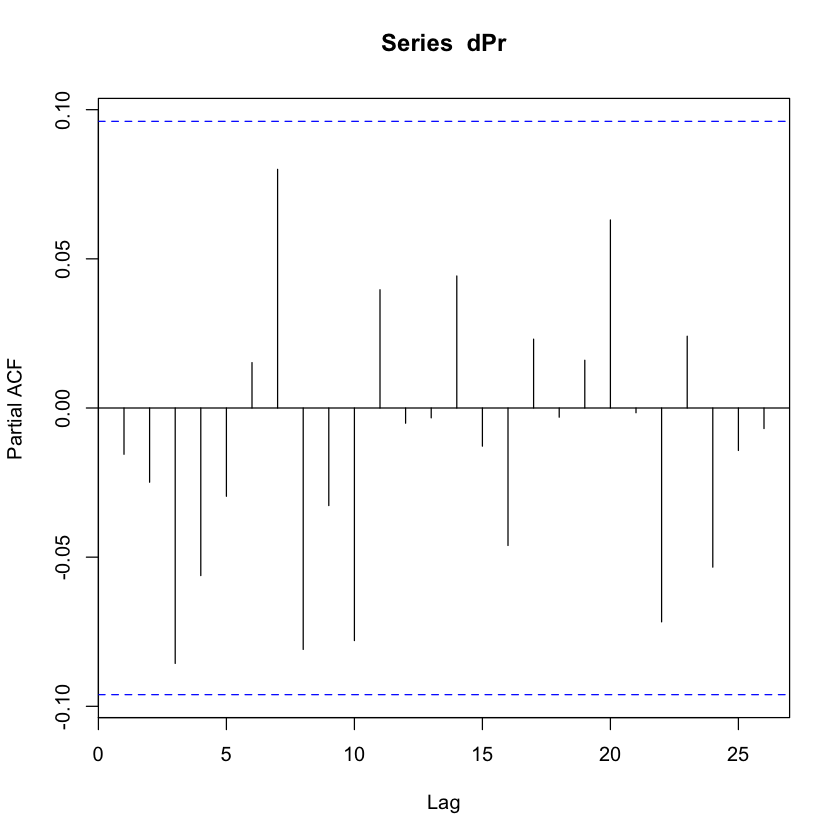

In [6]:
#Generación de features o rezagos y obtención base datos
#Obteneomos features:
tsfeatures(Pr_df_tra$META)
pacf_features(Pr_df_tra$META)
#Visualiamos los rezagos autorregresivos, haciendo estacionaria la serie:
dPr<-diff(Pr_df_tra$META)%>% na.omit() # Train section.
pacf(dPr)

In [7]:
#Generamos retrasos
lag_pr = lag(Pr_df_tra,n=3L) 
lag2_pr = lag(Pr_df_tra,n=7L) 
lag3_pr = lag(Pr_df_tra,n=8L)
lag4_pr = lag(Pr_df_tra,n=10L)

#Unimos los nuevos features o retrasos en una base
Pr_all_train<-cbind(Pr_df_tra, lag_pr, lag2_pr, lag3_pr, lag4_pr) %>%na.omit()
colnames(Pr_all_train)<-c("META","l3","l7","l8","l10")
head(Pr_all_train)

,META,l3,l7,l8,l10
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2016-05-16,118.67,119.52,117.81,118.06,118.57
2016-05-17,117.35,120.28,119.49,117.81,117.43
2016-05-18,117.65,119.81,119.24,119.49,118.06
2016-05-19,116.81,118.67,120.50,119.24,117.81
2016-05-20,117.35,117.35,119.52,120.50,119.49
2016-05-23,115.97,117.65,120.28,119.52,119.24


In [8]:
Pr_all_train$trend = 1:nrow(Pr_all_train)
#Separamos objetos para las secciones de entrenamiento con todos los features X_train:
x_train <- Pr_all_train %>% 
  select(starts_with(c("l", "t")))
#Igual para la respuesta y_train:
y_train <- Pr_all_train %>% 
  select(META)

**5.2 Preprocesamiento SSA**

In [9]:
# Un paso importante que hay que hacer, es pasar los datos de formato xts a ts, que es el formato que emplea SSA. para ello, pasamos primero a data frame
# y luego a ts.
META <- data.frame(date=index(META), coredata(META))
META1<-META$META
##pasamos a ts
META.ts<-ts(META1, start=c(2016,122), frequency = 365)

## Preprocesamiento: Partición de datos en conjunto de prueba y de entrenamiento.
## Podemos partir la serie en a manera de obtener 36 datos para la prueba. 
h <- round(length(META.ts)*0.05, digits = 0)

#Una vez creada la ventana h, generamos los conjuntos de entrenamiento y prueba.
train<-META.ts[1:(length(META.ts)-h)]
test<-META.ts[(length(META.ts)-h+1):length(META.ts)]
train.ts=ts(train,start=c(2016,05), frequency = 365)

### **6. Aplica cada uno de los modelos MARS, LSTM, RF y SSA a la serie de META**

**6.1 MARS**

In [10]:
mars_mod <- earth(
  META ~ ., data=Pr_all_train, pmethod="backward" )
# Podemos ver el resultado del modelo:
print(mars_mod)

Selected 4 of 5 terms, and 2 of 5 predictors
Termination condition: RSq changed by less than 0.001 at 5 terms
Importance: l3, trend, l7-unused, l8-unused, l10-unused
Number of terms at each degree of interaction: 1 3 (additive model)
GCV 6.754156    RSS 2655.196    GRSq 0.9857974    RSq 0.9862141


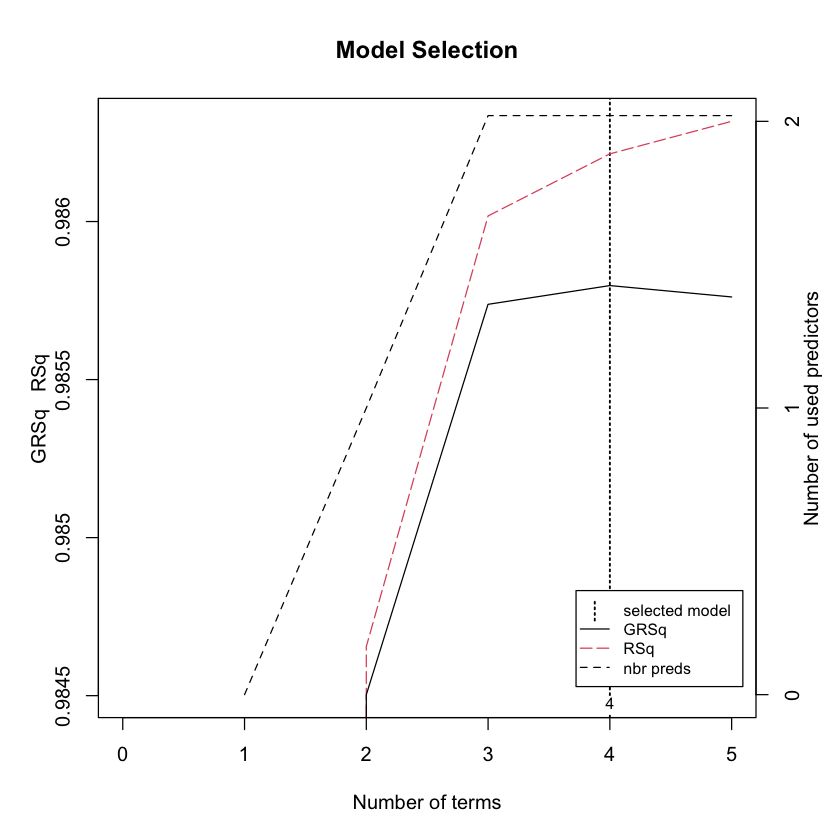

In [11]:
plot(mars_mod, which = 1)

In [12]:
# Unimos las base junto con los resultados de ajuste
Pr_train <- Pr_all_train %>% 
  mutate(
    fitted_mars = fitted(mars_mod)[,1]
  )

#Damos formato de xts para poder manipular los datos y graficarlos con ggplot más adelante
x <- as.xts(Pr_train, dateFormat = "Date")
Pr_train2 <- fortify.zoo(x)

# Podemos dar formato para que el etiquetado en la visualización sea más sencilla.
Pr_train3 <- Pr_train2 %>% 
  select(Index, META, starts_with("fitted")) %>% 
  gather("model", "value", -Index, -META) %>% 
  mutate(model = str_remove(model, "fitted_"))
tail(Pr_train3)

,Index,META,model,value
,<date>,<dbl>,<chr>,<dbl>
402,2017-12-15,180.18,mars,179.3978
403,2017-12-18,180.82,mars,180.5558
404,2017-12-19,179.51,mars,180.6754
405,2017-12-20,177.89,mars,180.0363
406,2017-12-21,177.45,mars,179.6480
407,2017-12-22,177.20,mars,180.5794


Graficas del modelo MARS

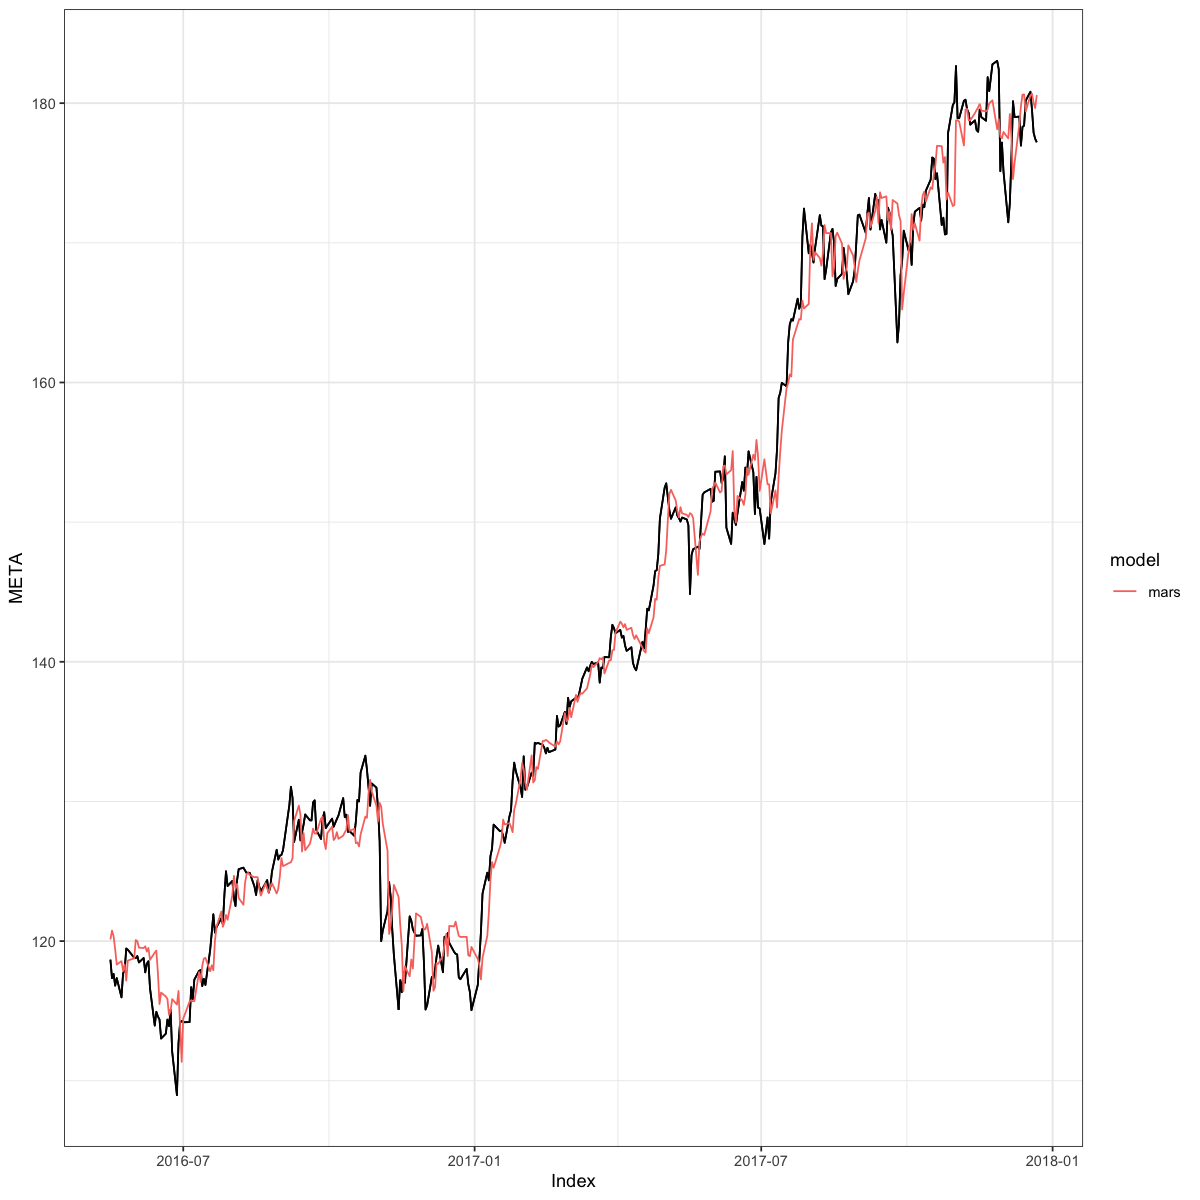

In [13]:
## Graficamos:
library(ggplot2)
options(repr.plot.width = 10, repr.plot.height = 10)
ggplot(Pr_train3,aes(Index,META))+geom_line() +
geom_line()+
geom_line(aes(y=value, color=model))
#theme(plot.title = element_text(size=30), legend.position="upper", cex=100)

**6.2 SSA**

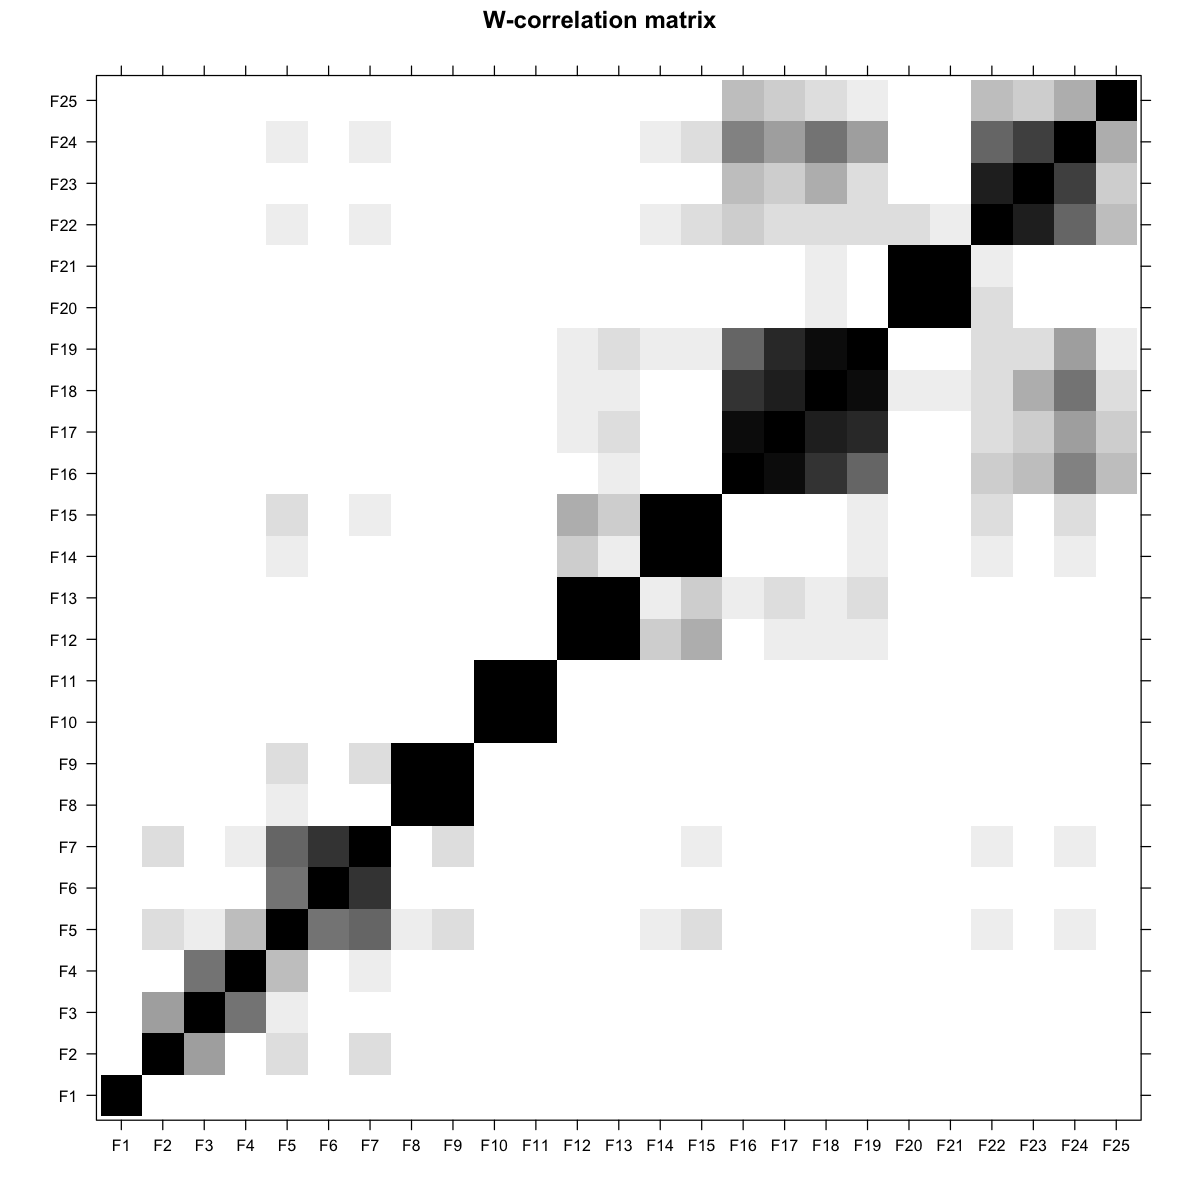

In [14]:
#En estos pasos, aplicamos la función de ssa() a la serie en formato ts y procedemos a la selección para la recosntrucción.
##SSA embeding y separación:
s1<-ssa(train.ts)  #Hay otros métodos como el "topelitz", para series estacionarias. En este caso no aplica.
##Reconstrucción: empleamos las herramientas visuales para la selección.
wplot<-wcor(s1, group=1:25)
plot(wplot)

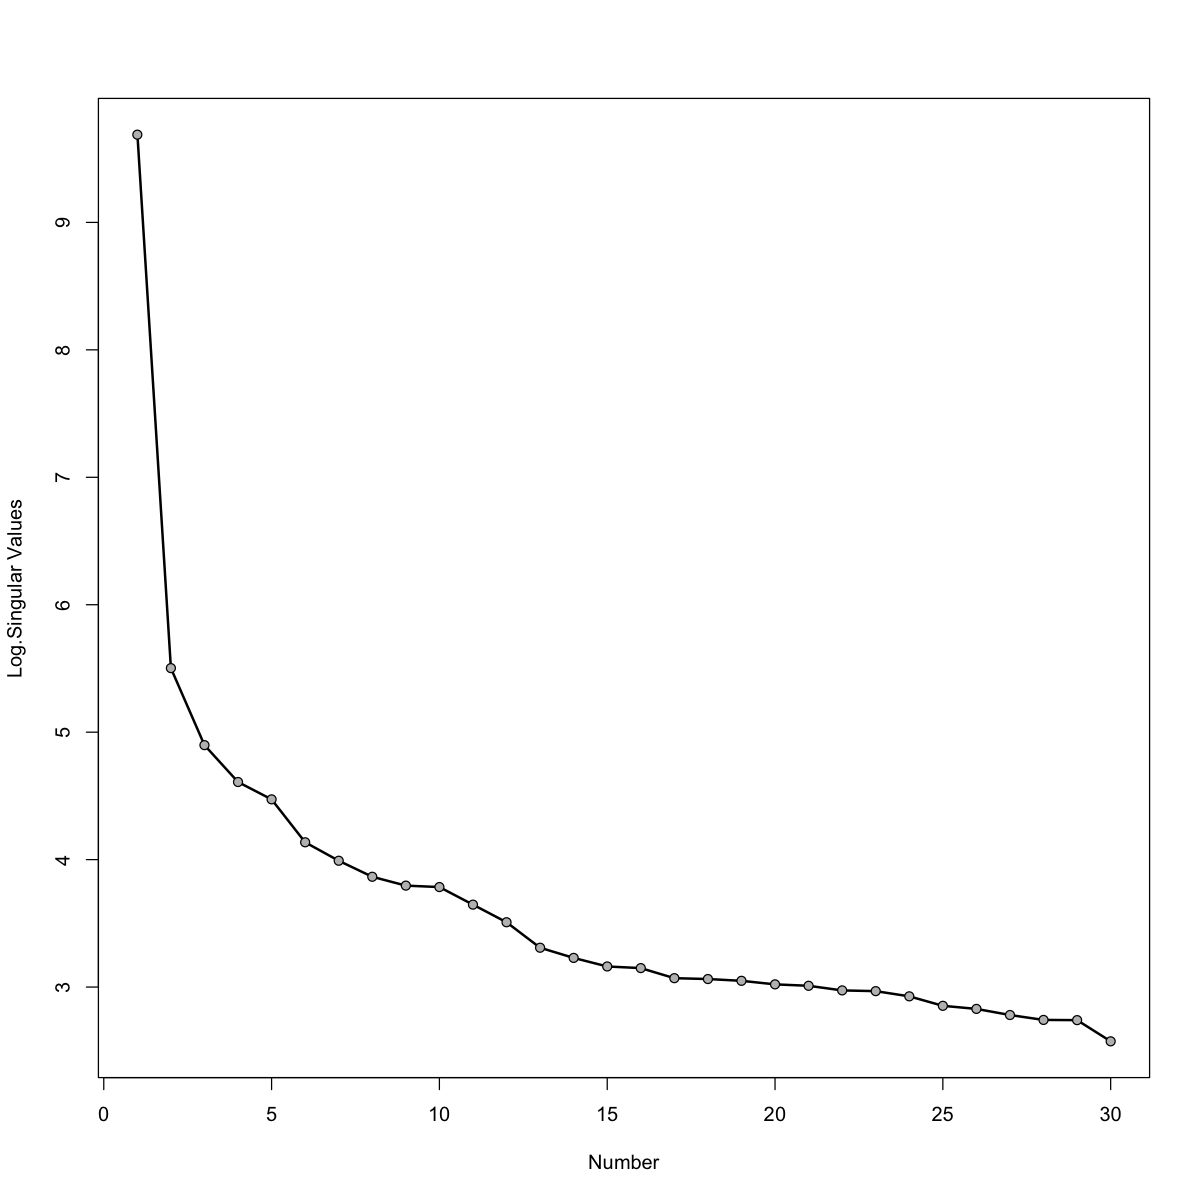

In [15]:
##Hankelización:
UniHankel=function(Y,L){
  k<-length(Y)-L+1
  outer((1:L), (1:k), function(x,y) Y[(x+y-1)])
}

##Función SVD
SVD<- function(Y,L){
  X<-UniHankel(Y,L)
  svd(X)
}

###W-correlation
W.corr<-function(Yt,L, groups){
  m<-length(groups); w.corr<-diag(m)
  N<-length(Yt)
  w<-((N+1)-abs((N+1)/2-L)-abs((N+1)/2-1:N)-
    abs(abs((N+1)/2-L)-abs((N+1)/2-1:N)))/2
wcorr<-function(i,j){
  Y1<-SSA.Rec(Yt,L,groups[[i]])$Approximation
  Y2<-SSA.Rec(Yt,L,groups[[j]])$Approximation
  sum(w*Y1*Y2)/sqrt(sum(w*Y1^2)*sum(w*Y2^2))}
for (i in 1:(m-1)){
  for (j in (i+1):m){
    w.corr[i,j]=w.corr[j,i]=wcorr(i,j)}}
rownames(w.corr)<-colnames(w.corr)<-groups
w.corr
}

###Plotting Images w.corr
Plt.Img<-function(x){
  min<-min(x)
  max<-max(x)
  yLabels<-rownames(x)
  xLabels<-colnames(x)
  if( is.null (xLabels)){
    xLabels <- c(1:ncol(x))
  }
  if (is.null(yLabels)){
    yLabels <- c(1:nrow(x))
  }
  layout(matrix(data=c(1,2), nrow=1, ncol=2),
         widths=c(4,1), heights=c(1,1))
  ColorRamp<-gray( seq(1,0, length=20))
  ColorLevels<-seq(min, max, length=length(ColorRamp))
                  par(mar=c(3,5,2.5,2))
                  image(1:length(xLabels), 1:length(yLabels),
                        t(x), col=colorRamp, xlab="",
                        ylab = "", axes=FALSE, zlim=c(min, max))
                  title(main=c("Image Plot"))
                  axis(BELOW<-1, at=1:length(xLabels),
                       labels=xLabels, cex.axis=0.7)
                  axis(LEFT<-2, at=1:length(yLabels),
                       labels=yLabels, las=HORIZONTAL<-1,
                       cex.axis=0.7)
                  box()
                  par(mar=c(3,2.5, 2.5,2))
                  image(1, ColorLevels,
                        matrix(data=ColorLevels, ncol=length(ColorLevels), nrow=1),
                        col=colorRamp,
                        xlab="", ylab="",
                        xaxt="n")
                  layout(1)
}

##Singular Values graph
Sing.plt<-function(Y,L){
  lambda<-log(SVD(Y,L)$d)
  d<-length(lambda)
  win<-1:d
  plot.new()
  plot.window(xlim=range(win), ylim=range(lambda))
  usr=par("usr")
  rect(usr[1], usr[3], usr[2], usr[4])
  lines(win, lambda, lwd=2)
  points(win, lambda, pch=21, bg="gray")
  axis(1)
  axis(2)
  box()
  title(xlab="Number")
  title(ylab="Log.Singular Values")}

        
#Tambien generamos la scree-plot.
Sing.plt(META.ts, 30)

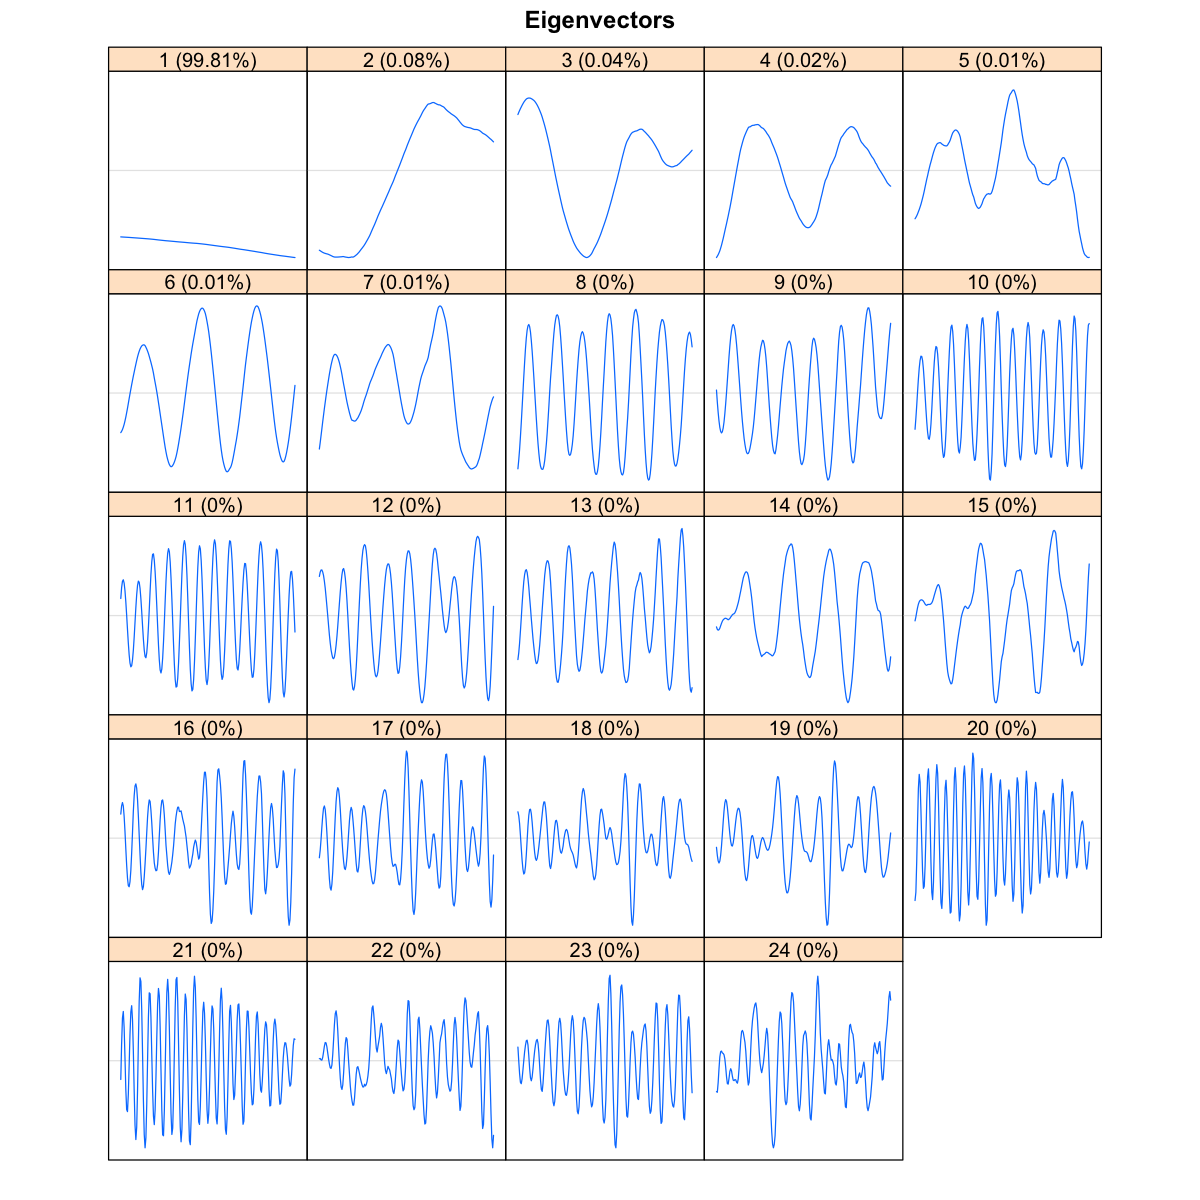

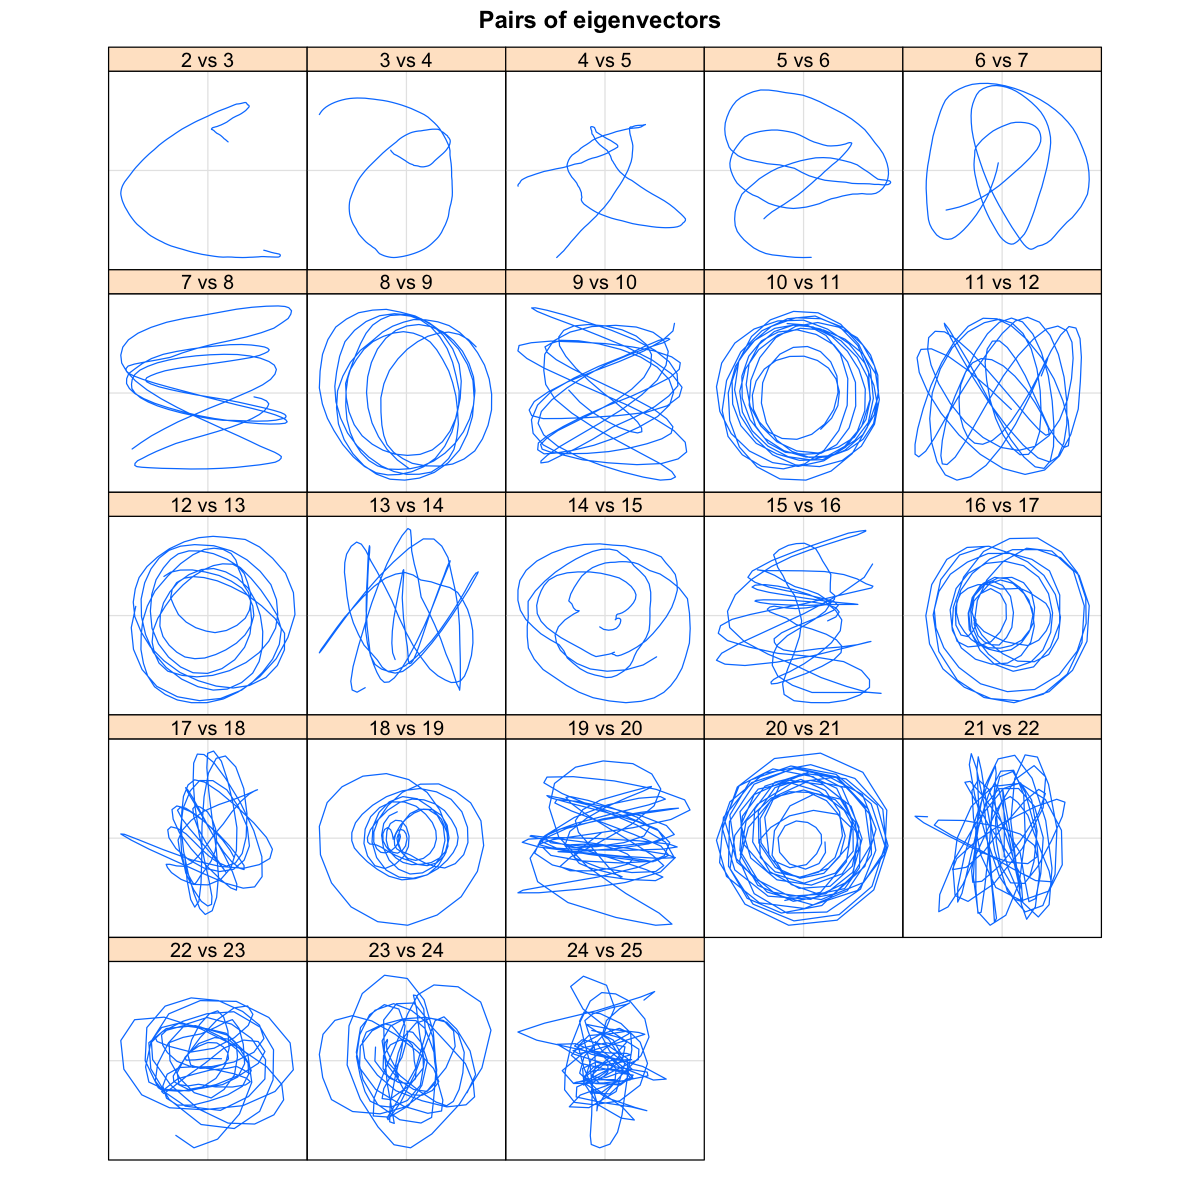

In [16]:
###Gráficas componentes 1D (compoente por componente) y la 2D (pares formen poligonos regulares : estables)
plot(s1, type="vectors", idx=1:24)
plot(s1, type= "paired", idx=2:24, plot.contrib = FALSE)

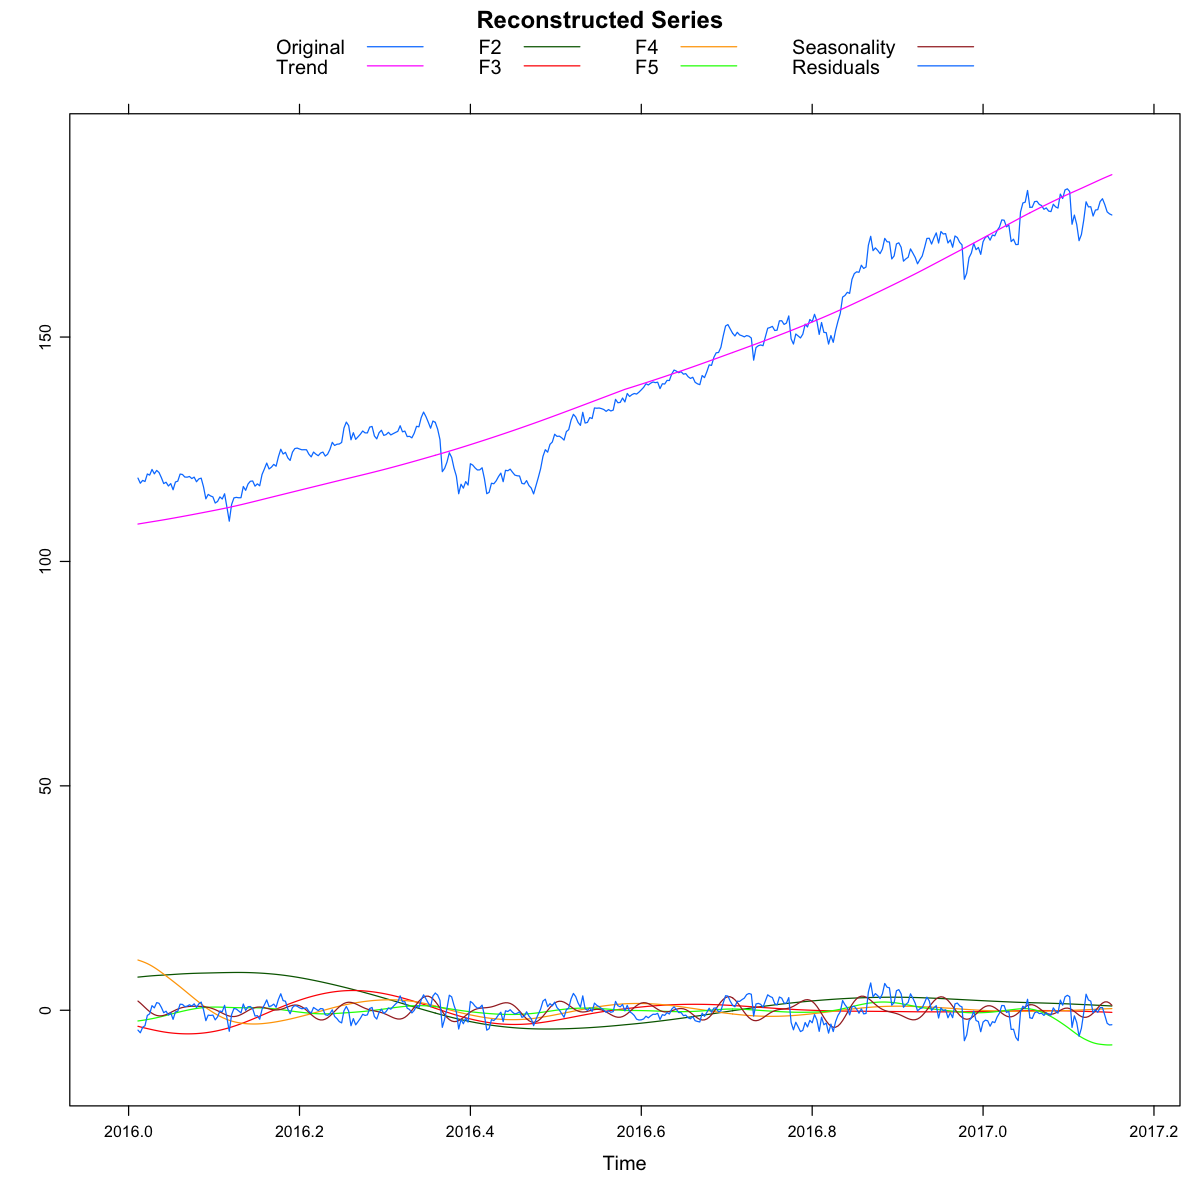

In [17]:
##Fase recontrucción:
r=reconstruct(s1, groups = list(Trend=1,2,3,4,5, Seasonality=c(8:9, 10:11, 12:13)))
plot(r, add.residuals=TRUE, add.original=TRUE, plot.method="xyplot",
     superpose=TRUE, auto.key=list(columns=4))

### **7. Empleando tus resultados, calcula las métricas para la medición de asertividad de un pronóstico, al menos debescalcular dos métricos de error de pronóstico, ejemplo: MAPE, RMSE, MAE, entre otros.**

**7.1 Validacion en conjunto de test con MARS**

 num [1:12] 164 163 163 163 163 ...


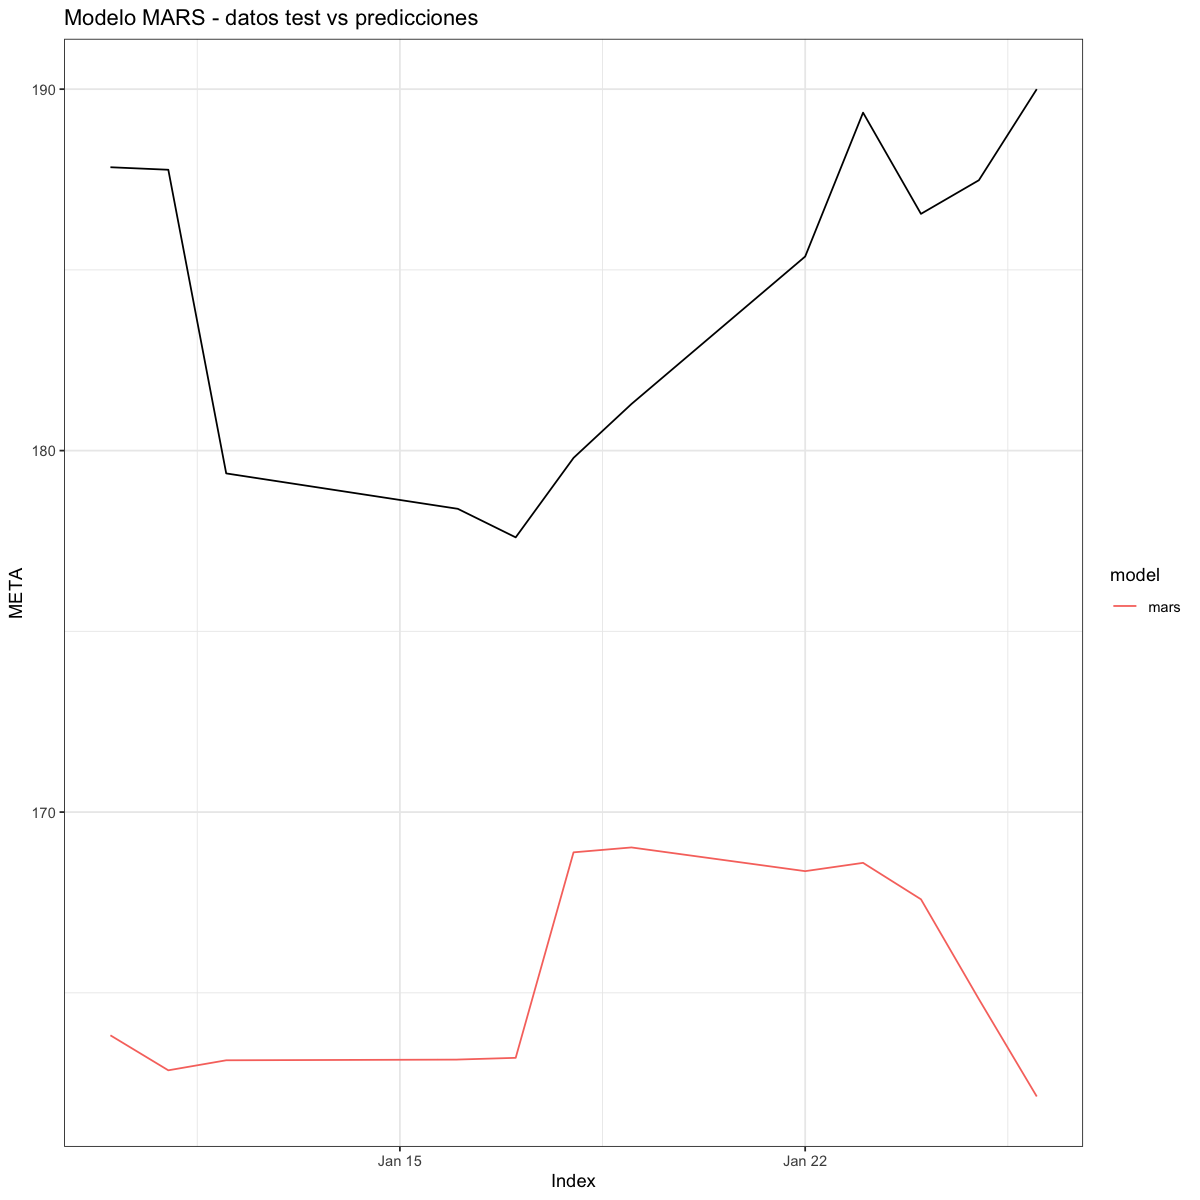

In [18]:
#Procedemos con pasar los datos de un formato xts, a un formato data.frame para facilitar la generación de rezagos.
Pr_test2<-as.data.frame(Pr_tes)
#Generación de rezagos o features: debemos generar los mismos tipos de features que en la parte de entrenamiento.
lag1_pr_test = lag(Pr_test2,n=3L) 
lag2_pr_test = lag(Pr_test2,n=7L) 
lag3_pr_test = lag(Pr_test2,n=8L) 
lag4_pr_test = lag(Pr_test2,n=10L) 

Pr_all_test<-cbind(Pr_test2, lag1_pr_test, lag2_pr_test, lag3_pr_test, lag4_pr_test) %>%na.omit()
colnames(Pr_all_test)<-c("META","l3","l7","l8","l10")
#Generamos la tendencia:
Pr_all_test$trend = 1:nrow(Pr_all_test)
#Renombramos:
colnames(Pr_all_test)<-c("META","l3","l7","l8","l10", "trend")

# Tambien, damos formato indexado a la fecha.
yt <- as.xts(Pr_all_test, dateFormat = "Date")
Pr_test2 <- fortify.zoo(yt)

#Neuvamente, podemos crear un objeto que contemple sólamente los rezagos o features de la parte de prueba, este sería el x_test.
x_test <- Pr_test2 %>% 
  select(starts_with(c("l", "t")))

##Llamamos de manera similar, a la respuesta de la parte de prueba.
y_test <- Pr_test2%>% 
  select(META)

#Modelo MARS
pred_mars = predict(mars_mod, x_test)[,1]
str(pred_mars)

#Podemos unir los resultados a manera que se generen columnas con los resultados de ajuste de los modelos:
Pr_test3 <- Pr_test2 %>% 
  mutate(
    pred_mars = predict(mars_mod, x_test)[,1]
  ) 

##Podemos graficar sólo el segmento de pronóstico:
Pr_test3 %>% 
  select(Index, META, starts_with("pred")) %>% 
  gather("model", "forecast", -Index, -META) %>% 
  mutate(model = str_remove(model, "pred_")) %>% 
  ggplot(aes(Index, META)) +
  geom_line() +
  geom_line(aes(y = forecast, color = model)) +
  ggtitle("Modelo MARS - datos test vs predicciones")  # Título del gráfico



In [19]:
# Metricas de desempeño modelo MARS
metrics_table <- bind_rows(
  yardstick::rmse(Pr_test3, truth = META, estimate = pred_mars),
  yardstick::mae(Pr_test3, truth = META, estimate = pred_mars),
  yardstick::mape(Pr_test3, truth = META, estimate = pred_mars)
)
metrics_table

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,19.44984
mae,standard,18.76902
mape,standard,10.13680


**7.2 Validacion en conjunto de test con SSA**

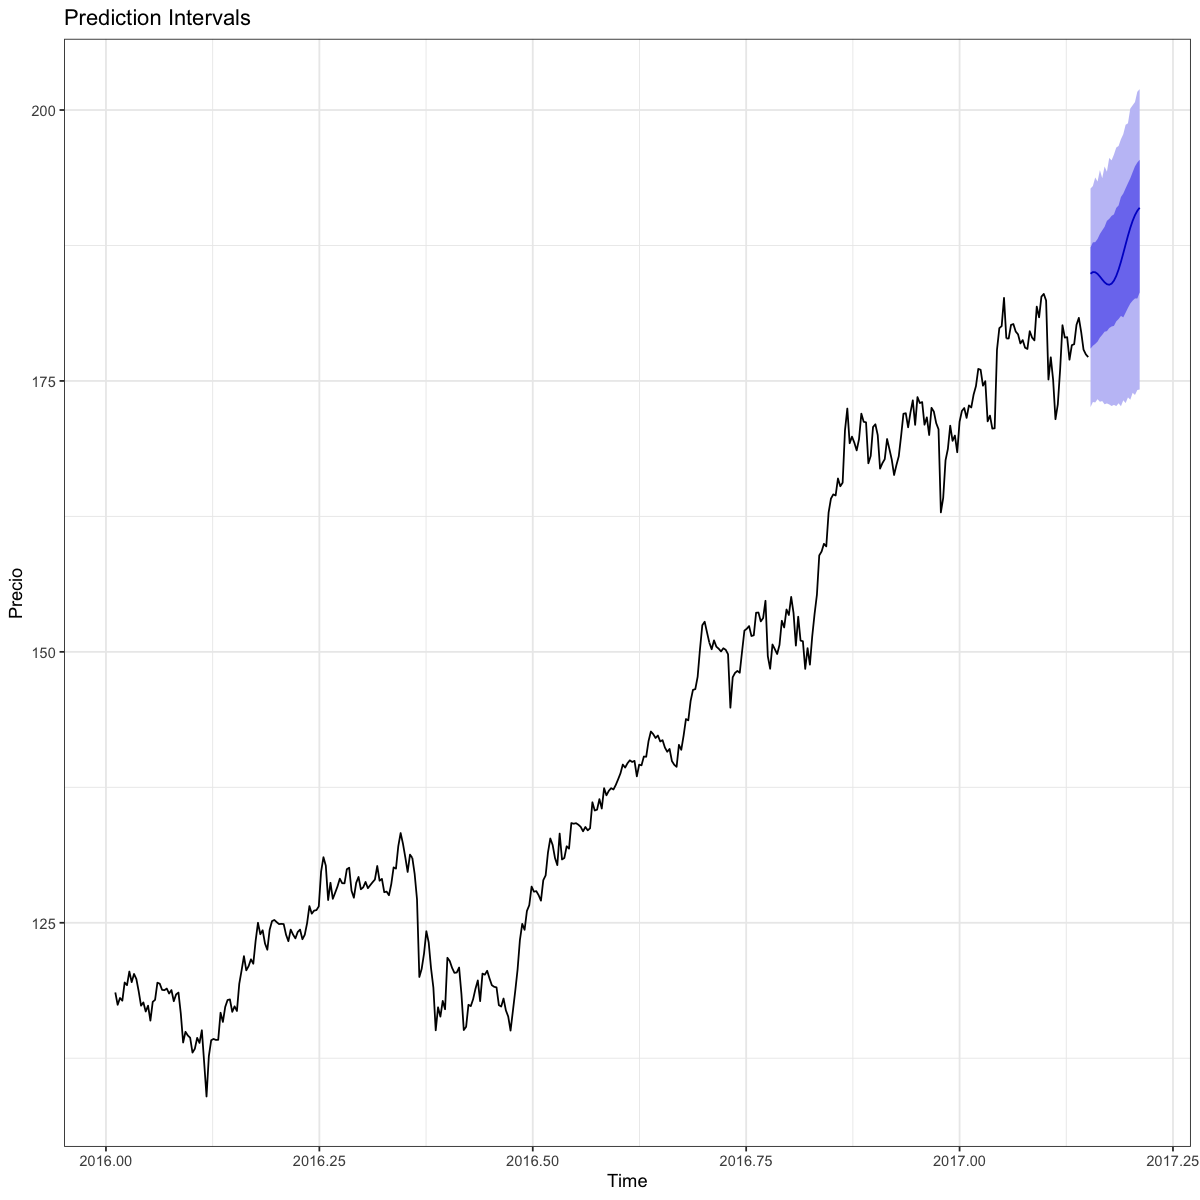

In [20]:
#Generamos el pronóstico señalando los tripletes de la reconstrucción.
pronostico1<-forecast(s1, groups = list(c(1:5,10:13)), len=h, method="recurrent", 
                                   interval = "prediction", level=c(0.8, 0.99),only.new=TRUE )
# Graficamos el pronóstico.
autoplot(pronostico1, type="l", main="Prediction Intervals", ylab="Precio")

pred<-pronostico1$mean


In [21]:
###Cálculo error MAPE, RMSE
RMSE1 <- Metrics::rmse(test, pred)
MAPE1 <- Metrics::mape(test, pred)
MAE1  <- Metrics::mae(test, pred)

RMSE1
MAE1
MAPE1_porcentaje <- MAPE1 * 100
MAPE1_porcentaje


[1] 5.476903

[1] 4.69289

[1] 2.594655

# **PASO 2:Comparación de los modelos y selección del mejor**

**1.Compara y sustenta qué modelo presentó un mejor desempeño de acuerdo a los criterios de selección pertinentes.**

| Modelo         | RMSE    | MAE    | MAPE (%) |
|----------------|---------|--------|----------|
| MARS           | 19.45   | 18.77  | 10.14    |
| LSTM           | 4.33    | 3.82   | 2.09     |
| Random Forest  | 6.15    | 5.12   | 2.75     |
| SSA            | 5.48    | 4.69   | 2.59     |

En base a las métricas obtenidas, el modelo LSTM muestra el mejor desempeño en términos de RMSE, MAE y MAPE, superando a los demás modelos con un RMSE de 4.33, MAE de 3.82 y un MAPE de 2.09%. Este desempeño es notablemente mejor en comparación con el modelo MARS (RMSE: 19.45, MAPE: 10.14%) y Random Forest (RMSE: 6.15, MAPE: 2.75%). Sin embargo, el modelo SSA también tiene buenos resultados con un MAPE de 2.59%, aunque sigue siendo menos preciso que el LSTM. Estos resultados sugieren que los modelos basados en redes neuronales, como el LSTM, pueden capturar mejor las complejas relaciones temporales en los datos de precios de acciones, mientras que los modelos más simples, como MARS y Random Forest, no logran igualar la precisión

In [23]:
summary(mars_mod)

Call: earth(formula=META~., data=Pr_all_train, pmethod="backward")

             coefficients
(Intercept)    169.312765
h(178.74-l3)    -0.830702
h(l3-178.74)    -0.676814
h(trend-144)     0.044821

Selected 4 of 5 terms, and 2 of 5 predictors
Termination condition: RSq changed by less than 0.001 at 5 terms
Importance: l3, trend, l7-unused, l8-unused, l10-unused
Number of terms at each degree of interaction: 1 3 (additive model)
GCV 6.754156    RSS 2655.196    GRSq 0.9857974    RSq 0.9862141